# Harmonic P and SV elastic waves in an unbounded solid

- Frequency-domain -- Helmoltz equation
- 2D
- Impedance absorbing boundary conditions
- Comparison with an analytical solution

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from dolfinx import mesh, fem, default_scalar_type
import ufl
from mpi4py import MPI
from petsc4py import PETSc

from elastodynamicsx.pde import material, BodyForce, boundarycondition, PDE
from elastodynamicsx.solvers import FrequencyDomainSolver
from elastodynamicsx.plot import plotter, live_plotter
from elastodynamicsx.utils import make_facet_tags, make_cell_tags, ParallelEvaluator

from analyticalsolutions import u_2D_PSV_xw, int_Fraunhofer_2D

assert np.issubdtype(default_scalar_type, np.complexfloating), \
       "Demo should only be executed with DOLFINx complex mode"

### FE domain

In [2]:
degElement = 1
length, height = 10, 10
Nx, Ny = 100//degElement, 100//degElement

# create the mesh
extent = [[0., 0.], [length, height]]
domain = mesh.create_rectangle(MPI.COMM_WORLD, extent, [Nx, Ny], mesh.CellType.triangle)

# create the function space
V = fem.FunctionSpace(domain, ("Lagrange", degElement, (domain.geometry.dim,)))

tag_left, tag_top, tag_right, tag_bottom = 1, 2, 3, 4
all_tags = (tag_left, tag_top, tag_right, tag_bottom)
boundaries = [(tag_left  , lambda x: np.isclose(x[0], 0     )),\
              (tag_right , lambda x: np.isclose(x[0], length)),\
              (tag_bottom, lambda x: np.isclose(x[1], 0     )),\
              (tag_top   , lambda x: np.isclose(x[1], height))]

# define some tags
facet_tags = make_facet_tags(domain, boundaries)

### Define the material law

isotropic elasticity

In [3]:
# parameters here...
rho     = fem.Constant(domain, default_scalar_type(1))
mu      = fem.Constant(domain, default_scalar_type(1))
lambda_ = fem.Constant(domain, default_scalar_type(2))
# ... end

mat = material(V, 'isotropic', rho, lambda_, mu)

### Boundary conditions
Plane-wave absorbing boundary conditions ('Dashpot')  
&emsp;$\sigma(u).n = \mathrm{i}\omega Z_N u_N + \mathrm{i}\omega Z_T u_T$ where $Z_{N,T}=\rho c_{L,T}$ is the normal/tangential acoustic impedance of the medium

In [4]:
Z_N, Z_T = mat.Z_N, mat.Z_T  # P and S mechanical impedances
bc  = boundarycondition((V, facet_tags, all_tags), 'Dashpot', Z_N, Z_T)

bcs = [bc]

### Source term (body force)
- Gaussian source

In [5]:
F0 = fem.Constant(domain, default_scalar_type([1, 0]))  # amplitude
R0 = 0.1  # radius
X0 = np.array([length/2, height/2, 0])  # center

x  = ufl.SpatialCoordinate(domain)
gaussianBF = F0 * ufl.exp(-((x[0]-X0[0])**2+(x[1]-X0[1])**2)/2/R0**2) / (2*np.pi*R0**2)

bf = BodyForce(V, gaussianBF)

### Assemble the PDE

In [6]:
pde = PDE(V, materials=[mat], bodyforces=[bf], bcs=bcs)

### Solve
0. Initialize the solver
1. Ex. 1: Solve for a single frequency
2. Ex. 2: Solve for several frequencies

In [7]:
# Initialize the solver
M, C, K = pde.M(), pde.C(), pde.K()  # Mass, damping and stiffness matrices (PETSc.Mat)
b = pde.init_b()  # declare the right-hand term (PETSc.Vec)
b_update_function = pde.update_b_frequencydomain  # will be called at each frequency by the solver
fdsolver = FrequencyDomainSolver(V.mesh.comm, M, C, K, b, b_update_function=b_update_function)

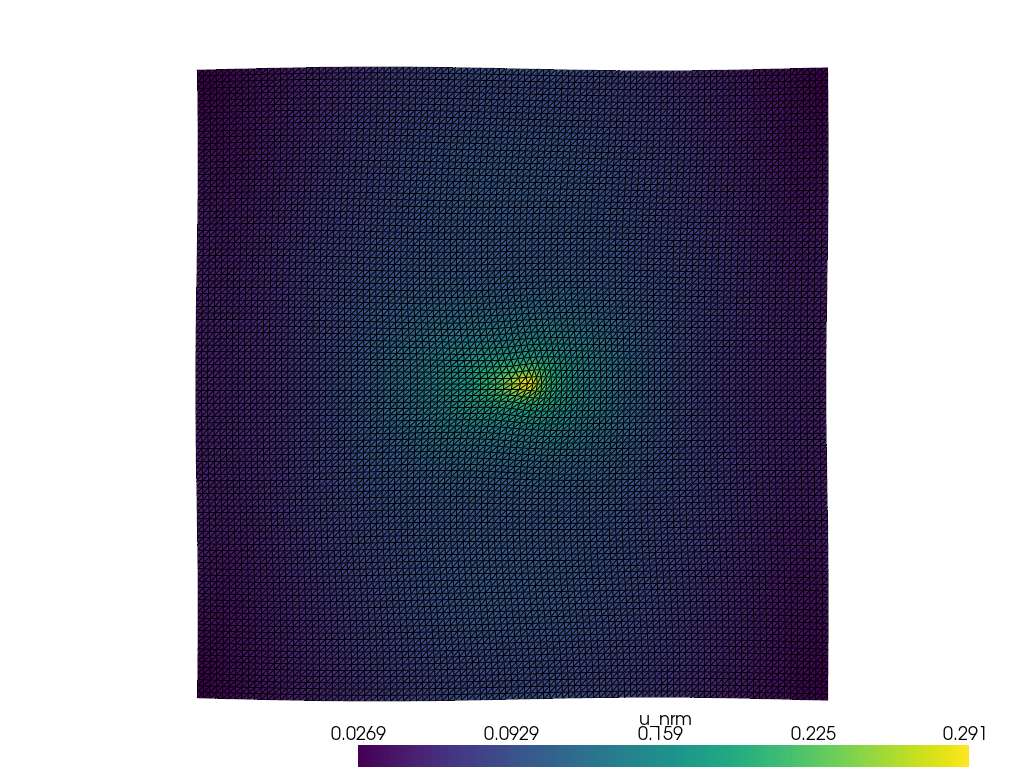

In [8]:
# -----------------------------------------------------
#          Ex 1: Solve for a single frequency
# -----------------------------------------------------
# Frequency to solve for
omega = 1.0

# Declare solution
u_res = fem.Function(V, name='solution')

# Solve
fdsolver.solve(omega=omega, out=u_res.vector)

# Plot
if domain.comm.rank == 0:
    p = plotter(u_res, complex='real')
    p.show()

# ------------------ end of Ex 1 ----------------------

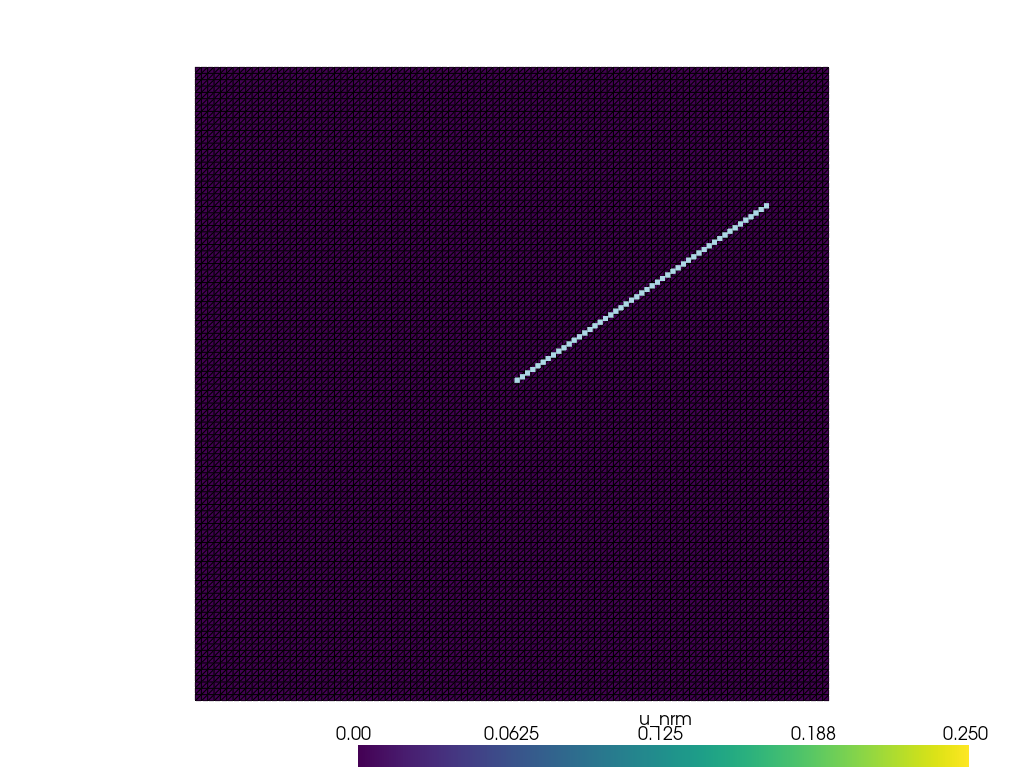

  0%|          | 0/5 [00:00<?, ?it/s]

In [9]:
# -----------------------------------------------------
#          Ex 2: Solve for several frequencies
# -----------------------------------------------------
# Frequencies to solve for
omegas = np.linspace(0.5, 3, num=5)

# Declare solution
u_res = fem.Function(V, name='solution')

# Prepare post processing
# -> Extract field at few points
from scipy.spatial.transform import Rotation as R
theta = np.radians(35)
pts = np.linspace(0, length / 2, endpoint=False)[1:]
points_out = X0[:,np.newaxis] + R.from_rotvec([0, 0, theta]).as_matrix() @ np.array([pts,
                                                                                     np.zeros_like(pts),
                                                                                     np.zeros_like(pts)])

# Declare a convenience ParallelEvaluator
paraEval = ParallelEvaluator(domain, points_out)

# Declare data (local)
u_at_pts_local = np.zeros((paraEval.nb_points_local,
                           V.num_sub_spaces,
                           omegas.size),
                           dtype=default_scalar_type)  # <- output stored here

# Callback function: post process solution
def cbck_storeAtPoints(i, out):
    if paraEval.nb_points_local > 0:
        u_at_pts_local[:,:,i] = u_res.eval(paraEval.points_local, paraEval.cells_local)

# Live plotting
enable_plot = True
if domain.comm.rank == 0 and enable_plot:
    p = live_plotter(u_res, clim=0.25 * np.linalg.norm(mu.value * F0.value) * np.array([0, 1]))
    if paraEval.nb_points_local > 0:
        p.add_points(paraEval.points_local)  # add points to live_plotter
else:
    p = None

# Solve
fdsolver.solve(omega=omegas, out=u_res.vector, callbacks=[cbck_storeAtPoints], live_plotter=p)

### Post-processing
- Plot the field at selected points
- Compare with an analytical solution

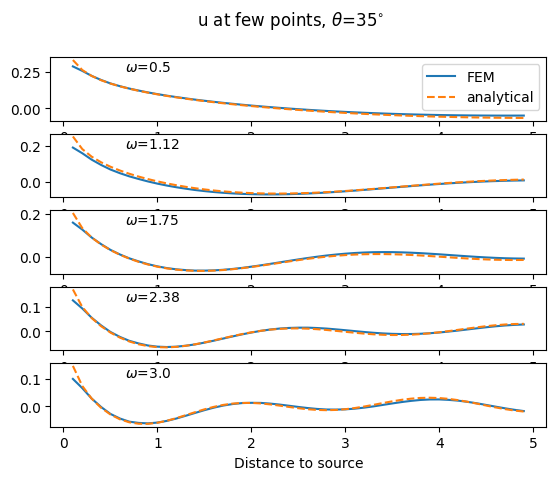

In [10]:
# Gather the data to the root process
u_at_pts = paraEval.gather(u_at_pts_local, root=0)

if domain.comm.rank == 0:
    ### -> Exact solution, At few points
    x = points_out.T

    # account for the size of the source in the analytical formula
    fn_kdomain_finite_size = int_Fraunhofer_2D['gaussian'](R0)
    u_at_pts_anal = u_2D_PSV_xw(x-X0[np.newaxis,:], omegas, F0.value, rho.value,
                                lambda_.value, mu.value, fn_kdomain_finite_size)

    #
    fn = np.real

    icomp = 0
    fig, ax = plt.subplots(len(omegas),1)
    fig.suptitle(r'u at few points, $\theta$=' + str(int(round(np.degrees(theta), 0))) + r'$^{\circ}$')
    r = np.linalg.norm(x - X0[np.newaxis,:], axis=1)
    for i in range(len(omegas)):
        ax[i].text(0.15, 0.95, r'$\omega$=' + str(round(omegas[i], 2)),
                   ha='left', va='top', transform=ax[i].transAxes)
        ax[i].plot(r, fn(u_at_pts[:, icomp, i]), ls='-' , label='FEM')
        ax[i].plot(r, fn(u_at_pts_anal[:, icomp, i]), ls='--', label='analytical')
    ax[0].legend()
    ax[-1].set_xlabel('Distance to source')
    plt.show()
#
# ------------------ end of Ex 2 ----------------------